The SSVQE uses a simple technique to find the excited energy states. Using the appropriate ansatz, VQE transforms the basis state into the ground state. All quantum computing transformations are unitary. Unitary transformations maintains the angles between vectors, so orthogonal states before transformations remains as orthognal states after transformation. So, SSVQE transforms |0⋯0⟩ to the ground state, and another orthogonal basis state |0⋯1⟩ to the first excited state and so on. This method bypasses the need for a "swap test" which is necessary to measure the inner product between the states to check orthogonality. Bypassing the swap test means that the quantum circuit can constructed with lower number of SWAP gates resulting in a shallower efficent quantum circuit. Hence, the overall computational time and total error becomes lower. So, SSVQEs are advantageous for the current NISQ devices.

# Imports

In [1]:
from qiskit.circuit.library.standard_gates import RXGate, RZGate, CXGate, CZGate, SGate, HGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from typing import Dict, Tuple, List
import matplotlib
from qiskit import assemble, Aer
from qiskit import IBMQ
from qiskit import *
from qiskit.visualization import plot_histogram
import math
import numpy as np
from numpy import linalg as LA
from qiskit.opflow import X, Z, I, H, Y
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit.quantum_info import Pauli

# Setting the BFGS optimazer and Backend

In [2]:
bfgs_optimizer = L_BFGS_B(maxiter=60)

simulator_backend = Aer.get_backend('qasm_simulator') 

# Implement the ansatz

In [3]:
def anzats_circ1(thetas, D2, in_state):
    qr = QuantumRegister(4, name="q")
    qc = QuantumCircuit(qr)
    qc.initialize(in_state)
        
    for d in range(D2):
        qc.append(RXGate(thetas[0]), [qr[0]])
        qc.append(RXGate(thetas[1]), [qr[1]])
        qc.append(RXGate(thetas[2]), [qr[2]])
        qc.append(RXGate(thetas[3]), [qr[3]])
        
        qc.append(RZGate(thetas[4]), [qr[0]])
        qc.append(RZGate(thetas[5]), [qr[1]])
        qc.append(RZGate(thetas[6]), [qr[2]])
        qc.append(RZGate(thetas[7]), [qr[3]])
        
        qc.append(CZGate(), [qr[0], qr[1]])
        qc.append(CZGate(), [qr[1], qr[2]])
        qc.append(CZGate(), [qr[2], qr[3]])
        qc.barrier(qr)
    
    qc.append(RXGate(thetas[0]), [qr[0]])
    qc.append(RXGate(thetas[1]), [qr[1]])
    qc.append(RXGate(thetas[2]), [qr[2]])
    qc.append(RXGate(thetas[3]), [qr[3]])

    qc.append(RZGate(thetas[4]), [qr[0]])
    qc.append(RZGate(thetas[5]), [qr[1]])
    qc.append(RZGate(thetas[6]), [qr[2]])
    qc.append(RZGate(thetas[7]), [qr[3]])
       
    return qc

def anzats_circ1_uninitialized(thetas, D2):
    qr = QuantumRegister(4, name="q")
    qc = QuantumCircuit(qr)
        
    for d in range(D2):
        qc.append(RXGate(thetas[0]), [qr[0]])
        qc.append(RXGate(thetas[1]), [qr[1]])
        qc.append(RXGate(thetas[2]), [qr[2]])
        qc.append(RXGate(thetas[3]), [qr[3]])
        
        qc.append(RZGate(thetas[4]), [qr[0]])
        qc.append(RZGate(thetas[5]), [qr[1]])
        qc.append(RZGate(thetas[6]), [qr[2]])
        qc.append(RZGate(thetas[7]), [qr[3]])
        
        qc.append(CZGate(), [qr[0], qr[1]])
        qc.append(CZGate(), [qr[1], qr[2]])
        qc.append(CZGate(), [qr[2], qr[3]])
        qc.barrier(qr)
    
    qc.append(RXGate(thetas[0]), [qr[0]])
    qc.append(RXGate(thetas[1]), [qr[1]])
    qc.append(RXGate(thetas[2]), [qr[2]])
    qc.append(RXGate(thetas[3]), [qr[3]])

    qc.append(RZGate(thetas[4]), [qr[0]])
    qc.append(RZGate(thetas[5]), [qr[1]])
    qc.append(RZGate(thetas[6]), [qr[2]])
    qc.append(RZGate(thetas[7]), [qr[3]])
    
    
    return qc

def anzats_circ2(phis, D1, in_state):
    qr = QuantumRegister(4, name="q")
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(qr, cr)
    qc.initialize(in_state)
    
    for d in range(D1):
        qc.append(RXGate(phis[0]), [qr[2]])
        qc.append(RXGate(phis[1]), [qr[3]])
        
        qc.append(RZGate(phis[2]), [qr[2]])
        qc.append(RZGate(phis[3]), [qr[3]])
        
        qc.append(CZGate(), [qr[2], qr[3]])
        qc.barrier(qr)
    return qc

# Choose k orthogonal states(computational basis)

In [4]:
def get_k_basis(k, n):
    full_basis = np.identity(n)
    return full_basis[:k]

# Generating the hamiltonians

In [5]:
from qiskit.opflow import X, Z, Y, I, H, S

H2_molecule_Hamiltonian =   -0.8105479805373279 * (I^I^I^I) \
                            + 0.1721839326191554 * (I^I^I^Z) \
                            - 0.22575349222402372 * (I^I^Z^I) \
                            + 0.17218393261915543 * (I^Z^I^I) \
                            - 0.2257534922240237 * (Z^I^I^I) \
                            + 0.12091263261776627 * (I^I^Z^Z) \
                            + 0.16892753870087907 * (I^Z^I^Z) \
                            + 0.045232799946057826 * (Y^Y^Y^Y) \
                            + 0.045232799946057826 * (X^X^Y^Y) \
                            + 0.045232799946057826 * (Y^Y^X^X) \
                            + 0.045232799946057826 * (X^X^X^X) \
                            + 0.1661454325638241 * (Z^I^I^Z) \
                            + 0.1661454325638241 * (I^Z^Z^I) \
                            + 0.17464343068300453 * (Z^I^Z^I) \
                            + 0.12091263261776627 * (Z^Z^I^I)

LiH_molecule_hamiltonian =  -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

# Expectation Value 

### convert hamiltonian to pauli strings

In [6]:
reducing_to_pauli_z_dict = {
    Pauli('I'): Pauli('I'),
    Pauli('Z'): Pauli('Z'),
    Pauli('X'): Pauli('Z'),
    Pauli('Y'): Pauli('Z')
} 

In [7]:
def transfrom_hamiltonian_into_pauli_string(hamiltonian):
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    return (pauli_strings, pauli_coeffs)

def reduce_pauli_matrixes_into_sigma_z(pauli_string):
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = pauli_string[matrix_index]
        pauli_string[matrix_index].insert(reducing_to_pauli_z_dict[pauli_matrix])
    
    return pauli_string

def get_z_reduction_for_pauli_string(qc, pauli_string):
    qr = QuantumRegister(4, name="q")
    exdend_qc = QuantumCircuit(qr)
    pauli_string = str(pauli_string)
    for qubit_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            exdend_qc.append(HGate(), [qr[qubit_index]])
        elif pauli_matrix == "Y":
            exdend_qc.append(HGate(), [qr[qubit_index]])
            exdend_qc.append(SGate(), [qr[qubit_index]])
    qc = qc.compose(exdend_qc)
    return qc

### probabilities distribution

In [8]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, BACKEND) 
#     Qobj = assemble(transpiled_quantum_state_circuit)
    result = BACKEND.run(transpiled_quantum_state_circuit).result()
    counts = result.get_counts(transpiled_quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [9]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, probas_distribution):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

def get_expectation_value(pauli_string, probas_distribution):
        return calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                pauli_string, probas_distribution)
    

# Calculating the first target function

In [10]:
def calc_target_func1(thetas, basis, D2, Ham):
    target_func = 0
    pauli_strings, pauli_coeffs = transfrom_hamiltonian_into_pauli_string(Ham)
    
    for j in basis:
        total_expectation_value = 0
        for pauli_index, pauli_string in enumerate(pauli_strings):
            qc = anzats_circ1(thetas, D2, j)
            qc = get_z_reduction_for_pauli_string(qc, pauli_string)
            probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(qc)
            total_expectation_value += pauli_coeffs[pauli_index] * get_expectation_value(pauli_string, probas_distribution)
        
        target_func += total_expectation_value
        
    return target_func

def objective_func1(thetas):
    target_func = calc_target_func1(thetas, basis, D2, Ham)
    return target_func

# Calculating the second target function

In [11]:
def calc_target_func2(thetas_opt, phis, in_state, D1, D2, Ham):
    target_func = 0

    qc2 = anzats_circ2(phis, D1, in_state)
    qc1 = anzats_circ1_uninitialized(thetas_opt, D2)
   
    pauli_strings, pauli_coeffs = transfrom_hamiltonian_into_pauli_string(Ham)
    
    total_expectation_value = 0
    for pauli_index, pauli_string in enumerate(pauli_strings):
        qc = qc2.compose(qc1)
        qc = get_z_reduction_for_pauli_string(qc, pauli_string)
        probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(qc)
        total_expectation_value += pauli_coeffs[pauli_index] * get_expectation_value(pauli_string, probas_distribution)
            
    target_func += total_expectation_value
        
    return target_func

def objective_func2(phis):
    in_state = basis[i]
    target_func2 = calc_target_func2(thetas_opt, phis, in_state, D1, D2, Ham)
    approximated_energies.append(target_func2)
    print(target_func2)
    return target_func2

def objective_func2_neg(phis):
    return -1*objective_func2(phis)

# Calculate the difference between the algorithm result and actual result

In [12]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [13]:
def get_k_exact_eigenvalue_of_hamiltonian(hamiltonian, k):
    eigen_values = LA.eig(hamiltonian.to_matrix())[0]
    print(sorted(eigen_values, reverse=True))
    
    return sorted(eigen_values,reverse=True)[k]

In [14]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_k_exact_eigenvalue_of_hamiltonian(hamiltonian, k)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("Approximated K Eigenvalues:")
    print(approximated_eigenvalue)

    print("Approximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))

In [15]:
def calc_diff_from_actual_result(hamiltonian, algorithm_result):
    matrix = hamiltonian.to_matrix()
    eigen_values, eigen_vectors = LA.eig(matrix)
    eigen_values.sort()
    actual_result = eigen_values[k]
    print("The actual k'th energy is:")
    print(actual_result)
    diff = algorithm_result - actual_result
    print("The differnce between the actual value and the algorithm result is:")
    print(diff)

In [16]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[:100])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

# Implementing SSVQE

In [17]:
def SSVQE(qubits_num, k, d1, d2):  
    global QUBITS_NUM
    QUBITS_NUM = qubits_num
      
    global n
    n = 2 ** QUBITS_NUM
    
    global basis
    basis = get_k_basis(k,n)
    
    global D1, D2
    D1 = d1
    D2 = d2
    
    print("The Hamiltonian running SSVQE on is:")
    print(Ham)
    
#     point, value, nfev = minimize(objective_func1,x0=np.zeros(8),method="BFGS",options={"maxiter":50})
    point, value, nfev = bfgs_optimizer.optimize(8,objective_func1,initial_point=np.zeros(8))
    print(point)
    print("---point---")
    print(value)
    print("---value---")

    global thetas_opt
    thetas_opt = point
    
    global i
    i = np.random.randint(0,k)
    
#     point, value, nfev = minimize(objective_func2_neg,x0=np.array([1,1,1,1]),method="BFGS",options={"maxiter":50})
    point, value, nfev = bfgs_optimizer.optimize(4, objective_func2_neg, initial_point=np.array([1, 1, 1, 1]))
    print(point)
    print("---point---")
    print(value)
    print("---value---")
    
    base_energy = -value
    print("The SSVQE result for the k'th energy of the Hamiltonian given is:")
    print(base_energy)
    compare_exact_and_approximated_eigenvalue(Ham, base_energy)

# SSVQE With H2 Molecule Hamiltonian

The Hamiltonian running SSVQE on is:
-0.8105479805373279 * IIII
+ 0.1721839326191554 * IIIZ
- 0.22575349222402372 * IIZI
+ 0.17218393261915543 * IZII
- 0.2257534922240237 * ZIII
+ 0.12091263261776627 * IIZZ
+ 0.16892753870087907 * IZIZ
+ 0.045232799946057826 * YYYY
+ 0.045232799946057826 * XXYY
+ 0.045232799946057826 * YYXX
+ 0.045232799946057826 * XXXX
+ 0.1661454325638241 * ZIIZ
+ 0.1661454325638241 * IZZI
+ 0.17464343068300453 * ZIZI
+ 0.12091263261776627 * ZZII
[0. 0. 0. 0. 0. 0. 0. 0.]
---point---
-1.185441480931699
---value---
-0.3792038141721207
-0.3678473455393422
-0.3594273219821276
-0.3626554869001662
-0.36561606879317293
-0.23855868611061237
-0.27638287270226847
-0.25214650970602126
-0.2647616098839685
-0.2541677995852738
-0.30728582826401896
-0.30713772900037684
-0.3106389874758664
-0.3406186538033876
-0.31729646286784713
-0.3233723664813537
-0.3355854476157054
-0.3654709595456128
-0.3584227876569591
-0.33677571305429094
-0.3645245478812308
-0.35984899058657
-0.353135718230

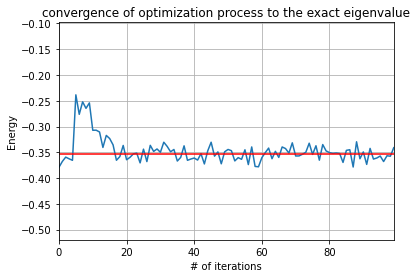

In [18]:
#Backend number of shots
NUM_SHOTS = 1024
BACKEND = simulator_backend

qubits_num = 4
k = 3
d1 = 2
d2 = 6
Ham = H2_molecule_Hamiltonian
approximated_energies= []

SSVQE(qubits_num, k, d1, d2)
plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue=-0.353325104107155, margin=1)

# SSVQE With LiH Molecule Hamiltonian

The Hamiltonian running SSVQE on is:
-7.49894690201071 * IIII
- 0.0029329964409502266 * XXYY
+ 0.0029329964409502266 * XYYX
+ 0.01291078027311749 * XZXI
- 0.0013743761078958677 * XZXZ
+ 0.011536413200774975 * XIXI
+ 0.0029329964409502266 * YXXY
- 0.0029329964409502266 * YYXX
+ 0.01291078027311749 * YZYI
- 0.0013743761078958677 * YZYZ
+ 0.011536413200774975 * YIYI
+ 0.16199475388004184 * ZIII
+ 0.011536413200774975 * ZXZX
+ 0.011536413200774975 * ZYZY
+ 0.12444770133137588 * ZZII
+ 0.054130445793298836 * ZIZI
+ 0.05706344223424907 * ZIIZ
+ 0.012910780273117487 * IXZX
- 0.0013743761078958677 * IXIX
+ 0.012910780273117487 * IYZY
- 0.0013743761078958677 * IYIY
+ 0.16199475388004186 * IZII
+ 0.05706344223424907 * IZZI
+ 0.054130445793298836 * IZIZ
- 0.013243698330265966 * IIZI
+ 0.08479609543670981 * IIZZ
- 0.013243698330265952 * IIIZ
[0. 0. 0. 0. 0. 0. 0. 0.]
---point---
-21.715402488291815
---value---
-7.582050570483492
-7.576178935924201
-7.579235096081023
-7.582367876898278
-7.571133041

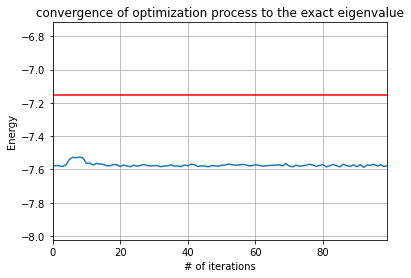

In [19]:
#Backend number of shots
NUM_SHOTS = 1024
BACKEND = simulator_backend

qubits_num = 4
k = 3
d1 = 2
d2 = 6
Ham = LiH_molecule_hamiltonian
approximated_energies=[]

SSVQE(qubits_num, k, d1, d2)
plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue=-7.151525481896562, margin=1)

# SSVQE With Ising Model Hamiltonian

The Hamiltonian running SSVQE on is:
0.0 * IIII
+ 0.8398088405253477 * XIII
+ 0.7989496312070936 * IXII
+ 0.38189710487113193 * ZZII
+ 0.057753122422666725 * IIXI
+ 0.5633292636970458 * ZIZI
+ 0.3152740621483513 * IZZI
+ 0.07209487981989715 * IIIX
+ 0.17892334004292654 * ZIIZ
+ 0.2273896497668042 * IZIZ
+ 0.09762902934216211 * IIZZ
[0. 0. 0. 0. 0. 0. 0. 0.]
---point---
6.501725720735498
---value---
1.40192055441865
1.3905019309024256
1.384577713984131
1.3702508797980537
1.362219761725518
1.344730666481431
1.3227050371172646
1.3459763137712646
1.3016432498396808
1.33443848012853
1.3706680740416648
1.3488905345628577
1.3668800905583893
1.3539077693739787
1.376996983374379
1.3705848991635445
1.3666704894136
1.3692284909292933
1.3744784115547417
1.3905631619212828
1.363190960065575
1.380060988994265
1.3782481399999293
1.3929726772886846
1.3203613249584711
1.3985945470770766
1.3435774727237324
1.3023644567811028
1.3662954780405676
1.3721201035940922
1.380206933049277
1.3175059140961078
1.34

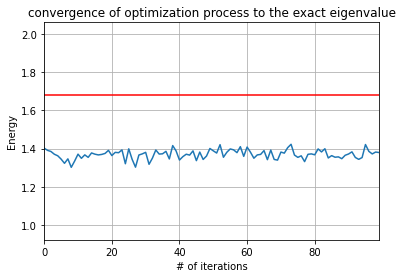

In [20]:
#Backend number of shots
NUM_SHOTS = 1024
BACKEND = simulator_backend

qubits_num = 4
k = 3
d1 = 2
d2 = 6
Ham = transverse_ising_4_qubits
approximated_energies = []

SSVQE(qubits_num, k, d1, d2)
plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue=1.6816520928402046, margin=1)